In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
sns.set_style('darkgrid')

## Preprocess for Transformer

In [2]:
# user-made library
from preprocess import split_data, preprocess_seq, cut_seq

In [3]:
# full data (# see preprocess_to_npy.ipynb)
train_full = np.load('data/train.npy')

isMini = False
if isMini:
    idx = np.random.randint(train_full.shape[0], size=1000)
    train_full = train_full[idx, :, :]


train_full.shape

(6343, 1500, 10)

In [5]:
# train, val split
train, val = train_test_split(train_full, random_state=1)
train.shape, val.shape

((4757, 1500, 10), (1586, 1500, 10))

In [6]:
# get input and target
input, target = preprocess_seq(train)

print(input.shape)
print(target.shape)

(4757, 1499, 1)
(4757, 1499, 1)


In [7]:
WINDOW_LEN = 300
STRIDE = 10

input_cut = cut_seq(input, window_len=WINDOW_LEN, stride=STRIDE)
target_cut = cut_seq(target, window_len=WINDOW_LEN, stride=STRIDE)
print(input_cut.shape)
print(target_cut.shape)

(570840, 300, 1)
(570840, 300, 1)


## DataLoader

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [13]:
BATCH_SIZE = 64

# DataLoader
input_tensor = torch.Tensor(input_cut)
target_tensor = torch.Tensor(target_cut)

train_dset = TensorDataset(input_tensor, target_tensor)
train_dloader = DataLoader(train_dset, shuffle=True, batch_size=BATCH_SIZE)

In [14]:
# Create validation data loader

input_val, target_val = preprocess_seq(val)
input_val_cut = cut_seq(input_val, window_len = WINDOW_LEN, stride=STRIDE)
target_val_cut = cut_seq(target_val, window_len = WINDOW_LEN, stride=STRIDE)

input_val_tensor = torch.Tensor(input_val_cut)
target_val_tensor = torch.Tensor(target_val_cut)

val_dset = TensorDataset(input_val_tensor, target_val_tensor)
val_dloader = DataLoader(val_dset, shuffle=False, batch_size=BATCH_SIZE)

print(input_val_tensor.shape)
print(target_val_tensor.shape)

torch.Size([190320, 300, 1])
torch.Size([190320, 300, 1])


## Train

In [15]:
import torch.nn as nn

from model import TransformerDecoder_fcst

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
# model
model = TransformerDecoder_fcst(fcst_mode = 'gauss',
                                      seq_len = WINDOW_LEN, 
                                      embedding_dim = 10, 
                                      nhead = 5, 
                                      num_layers = 2, 
                                      device=device).to(device)

In [13]:
# probabilistic(Gaussian) fcst

print(f'BATCH_SIZE:{BATCH_SIZE}')
print(f'WINDOW_LEN:{WINDOW_LEN}')
print(f'STRIDE:{STRIDE}')
print(f'isMini:{isMini}')

criterion = nn.GaussianNLLLoss()

optimizer = torch.optim.Adam(model.parameters() ,lr=1e-3, betas=(0.9, 0.98), weight_decay=1e-4)

# train
n_epoch = 30
train_loss_list = torch.zeros(n_epoch, device=device)
val_loss_list = torch.zeros(n_epoch, device=device)

print('Started training')

for epoch in range(n_epoch):
    model.train()
    running_train_loss = 0.0

    
    for i, data in enumerate(tqdm(train_dloader)):
        input, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        mean, var = model(input)
        loss = criterion(mean, target, var)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    
    # training loss
    train_loss = running_train_loss / len(train_dloader)
    train_loss_list[epoch] = train_loss
    print(f'[Epoch {epoch+1}] Train loss:', train_loss, end='\t')
    running_train_loss = 0.0

    # validation
    running_val_loss = 0.0
    with torch.no_grad():
        model.eval()
        
        for i, data in enumerate(val_dloader):
            input, target = data[0].to(device), data[1].to(device)
            mean, var = model(input)
            loss = criterion(mean, target, var)

            running_val_loss += loss.item()
        
        val_loss = running_val_loss / len(val_dloader)
        val_loss_list[epoch] = val_loss
        print('Val loss:', val_loss)
        running_val_loss = 0.0
            
print('Finished training')

# full, 128, 256 -> significant overfitting
# full, 512 -> memory problem

BATCH_SIZE:128
WINDOW_LEN:300
STRIDE:10
isMini:False
Started training
100%|██████████| 4460/4460 [10:19<00:00,  7.20it/s]
[Epoch 1] Train loss: -3.065059109920878	Val loss: -2.7694693680510687
100%|██████████| 4460/4460 [10:19<00:00,  7.19it/s]
[Epoch 2] Train loss: -3.8097480104643133	Val loss: 0.15169693060022313
100%|██████████| 4460/4460 [10:20<00:00,  7.19it/s]
[Epoch 3] Train loss: -4.223126268547212	Val loss: -1.1025633477111407
100%|██████████| 4460/4460 [10:20<00:00,  7.19it/s]
[Epoch 4] Train loss: -4.417068221493135	Val loss: 3.5284938937630543
100%|██████████| 4460/4460 [10:19<00:00,  7.19it/s]
[Epoch 5] Train loss: -4.491808560990098	Val loss: -3.3917074003472933
100%|██████████| 4460/4460 [10:19<00:00,  7.19it/s]
[Epoch 6] Train loss: -4.552354866800822	Val loss: -0.21893682623008534
100%|██████████| 4460/4460 [10:20<00:00,  7.19it/s]
[Epoch 7] Train loss: -4.6265196570767415	Val loss: -1.0616750161255264
100%|██████████| 4460/4460 [10:19<00:00,  7.19it/s]
[Epoch 8] Train

Text(0, 0.5, 'NLL')

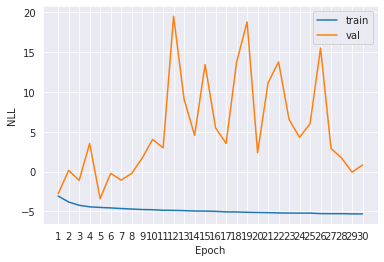

In [14]:
# Plot loss
train_loss_list_detached = train_loss_list.cpu().detach().numpy()
val_loss_list_detached = val_loss_list.cpu().detach().numpy()

xticks = np.arange(1, len(train_loss_list)+1)
plt.plot(xticks, train_loss_list_detached, label='train')
plt.plot(xticks, val_loss_list_detached, label='val')
plt.legend()
plt.xticks(xticks, xticks)
plt.xlabel('Epoch')
plt.ylabel('NLL')

In [19]:
# save model
torch.save(model.state_dict(), './model/full_conv.pkl')

## Plot sample prediction

In [18]:
# load model
model.load_state_dict(torch.load('./model/full_conv.pkl'))

<All keys matched successfully>

In [22]:
model.eval()

sample = next(iter(val_dloader))

input, target = sample[0].to(device), sample[1].to(device)
mean, var = model(input)

# real prediction (prediction of last element in the seq)

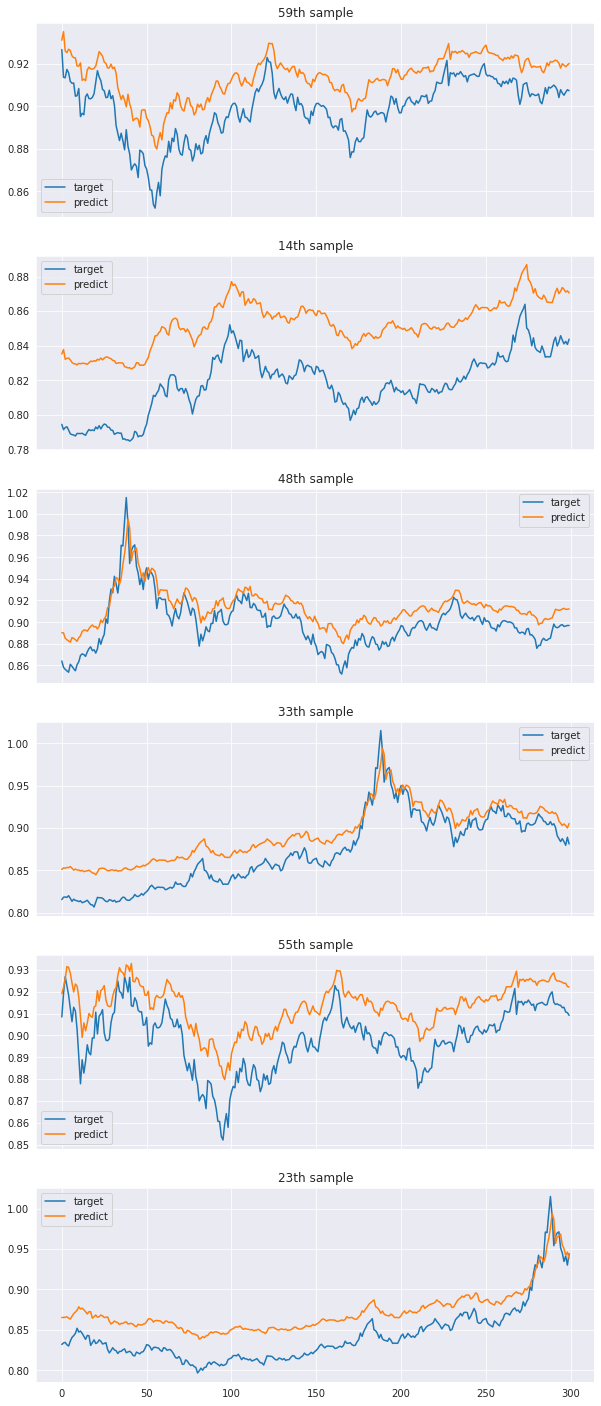

In [28]:
# short-term (rolling-minute prediction)
sample_nums = np.random.choice(64, 6)

fig, axs = plt.subplots(6,1, sharex=True, figsize=(10,25))


for i, sample_num in enumerate(sample_nums):
    axs[i].set_title(f'{sample_num}th sample')
    axs[i].plot(target[sample_num].cpu().detach().numpy().squeeze(-1), label='target')
    axs[i].plot(mean[sample_num].cpu().detach().numpy().squeeze(-1), label='predict')
    axs[i].legend()